Imports

In [ ]:
import numpy as np
from warnings import catch_warnings, simplefilter
import matplotlib.pyplot as plt
import math 
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
import os   

# Cleaning up the Dataset

In [ ]:


def load_images(folder_name):
    images = []
    filenames =[]
    for filename in os.listdir(folder_name):
        try:
            filepath = os.path.join(folder_name, filename)
            img = Image.open(filepath)
            filenames.append(filename)
            images.append(img)
        except Exception as error:
            print(f"Error loading {folder_name}: {error}")
    return images, filenames ###Returns images and pokemon names 

def image_processing(images):
    new_images = []
    for image in images:
        array_image = np.asarray(image).flatten()
        new_images.append(array_image)
    return new_images

image_data = "images"
pokemon_data = pd.read_csv("pokemon.csv")
pokemon_images, pokemon_names = load_images(image_data)
data = image_processing(pokemon_images)

for pokemon in pokemon_data: # Add each pokemon info to the correct column
    pass

pokemon_data['Image Data'] = data # Add array of Pokemon data to Image data sec
pokemon_Data = pokemon_data.dropna(subset = ['Image Data']) # Drop rows w/ N/A

print(pokemon_Data[['Name','Type1','Type2','Evolution']])

# Training Code

# An Introduction to Bayesian Hyperparameter Optimization

### Bayes Theorem 
Bayes theorem defines the probability of an event $A$ conditioned on an event $B$ as follows.

$$ P(A|B) = \frac{P(B | A) \ast P(A)}{P(B)} $$

Using this theorem, we can optimize a complicated function by creating an easier to calculate surrogate by sampling our original function. Then we continue to take samples that are most likely to improve our estimate of the best "score", making our surrogates estimations more and more accurate. This process is called **Bayesian Optimization**. Let's get started by defining an "objective" function (score function) and a basic Gaussian Process model below.

In [ ]:
# Imports
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings, simplefilter

In [ ]:
# Define an expensive objective function that we want to approximate
def objective(x, noise=0.1):
    random_noise = np.random.normal(scale=noise)
    return (2 * math.cos(2*x) * math.sin(x)) + random_noise

# Generate initial samples with noise
X = np.random.random(100).reshape(-1, 1)
y = np.array([objective(x) for x in X]).reshape(-1, 1)

# Instantiate the model
model = GaussianProcessRegressor()
model.fit(X, y)

In [ ]:
# Define a visualization function that plots prediction vs. actual
def visualize(X, y):
    plt.scatter(X, y)
    Xsamples = np.arange(0, 1, 0.001).reshape(-1, 1)
    ysamples = model.predict(Xsamples)
    plt.title("Initial Model Predictions")
    plt.plot(Xsamples, ysamples)
    plt.show()

# Visualize the initial data
visualize(X, y)

### Acquisition Function
Now we have the problem of exploration vs exploitation, often observed in reinforcement learning problems such as bandit optimization. How can we choose points such that we optimize the balance between exploring unknown points that could potentially be better than what we have and verifying our current highest scores, especially in a non-deterministic sample space? This is where acquisition functions come in, they use various heuristic methods to determine what points are most likely to improve the model's predictions. Some of these methods include:

- Probability of Improvement (PI): This is the simplest acquisition function. It focuses on the probability that a given point will improve upon the current best-known value. However, it often gets stuck in local optima due to its simplicity.
- Expected Improvement (EI): This function not only considers the probability of improvement but also takes into account the potential magnitude of improvement. It refines the approach by evaluating how much better a possible outcome could be.
- Entropy Search: This method selects points that will provide the most information gain, effectively balancing exploration across the sample space. It can be likened to traversing an extensive landscape of hills and valleys, seeking areas that offer the most insight.
- Upper Confidence Bound (UCB): UCB uses a balance factor to weigh between exploration and exploitation. It adjusts its strategy based on a confidence interval around predictions, allowing for a dynamic balance between trying new points and exploiting known high-value areas.

The technical workings of why these functions work and exactly how they differ from each other are beyond the scope of this class. However, it's worth knowing the functional differences. 

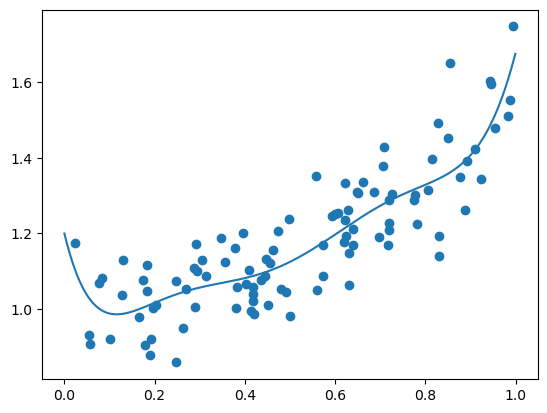

In [ ]:
# Define the acquisition function to calculate probability of improvement
def probability_of_improvement(X, Xsamples, xi=0.01):
    # Determine the best score from the surrogate model so far
    yhat = model.predict(X)
    best_score = max(yhat)

    # Calculate mean and standard deviation using the surrogate model
    mu, std = model.predict(Xsamples, return_std=True)

    # Compute probability of improvement
    probabilities = norm.cdf((mu - best_score - xi) / (std + 1E-9))
    return probabilities

# Function to optimize the acquisition function
def optimize_acquisition(X, y):
    # Generate random samples for exploration
    Xsamples = np.random.random(100).reshape(-1, 1)
    # Evaluate acquisition scores for each sample
    scores = probability_of_improvement(X, Xsamples)
    # Identify the sample with the highest score
    best_index = np.argmax(scores)
    return Xsamples[best_index, 0]

# Run optimization loop to improve sampling points iteratively
for i in range(100):
    next_sample = optimize_acquisition(X, y)
    actual_value = objective(next_sample)
    
    # Update dataset with new sample point and observation
    X = np.vstack((X, [[next_sample]]))
    y = np.vstack((y, [[actual_value]]))
    
    # Re-fit model with updated data
    model.fit(X, y)

# Final plot of all samples and surrogate model predictions
visualize(X, y)

# Identify and print the best result found during optimization
best_index = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[best_index], y[best_index]))

# Final Results